##### Projet de Reporting - Million Playlist Dataset

Membres du groupe :
- Hugo HOUNTONDJI
- LO Maty
- HU Angel
- PASINI Georgio


#### Hypoth√®ses √† v√©rifier

- Les morceaux plac√©s en d√©but de playlist ont une plus grande dur√©e moyenne.
- Un album est rarement repr√©sent√© par plus de 2 morceaux dans une playlist (les chansons normalement arrivent d'albums diff√©rents)
- Les playlists contiennent plus d'albums uniques que d'artistes (pour un artiste normalement il y a plusieurs albums).
- Les playlists avec plus de 50 morceaux ont une diversit√© d'artistes plus √©lev√©e (plus de num_artists).


#### Nettoyage des donn√©es

Ce script a pour objectif de :
Charger les fichiers de donn√©es brutes (JSON du MPD).
Aplatir la structure pour avoir une ligne par piste de playlist.
Nettoyer les donn√©es (gestion des valeurs nulles, des doublons, conversion des types).
Sauvegarder le jeu de donn√©es propre dans un fichier CSV (`alcrowd_cleaned.csv`) qui servira de base pour toutes les analyses futures.


In [12]:
# Importation des biblioth√®ques
import pandas as pd
import os
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("Nous d√©butons par l'importation des biblioth√®ques")


Nous d√©butons par l'importation des biblioth√®ques


In [13]:
#################################################################################################

# Chargement et fusion des donn√©es
# Nous avons du adapter l'importation des donn√©es pour le notebook
base_dir = os.getcwd()
alcrowd_path = os.path.join(base_dir, 'alcrowd')
output_dir = alcrowd_path
os.makedirs(output_dir, exist_ok=True)

#################################################################################################

# Chargement des fichiers JSON
json_files = glob.glob(os.path.join(alcrowd_path, 'mpd.slice.*.json'))
all_playlists = []

if len(json_files) > 0:
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            all_playlists.extend(data['playlists'])
    print(f"Chargement de {len(all_playlists)} playlists")
else:
    # Tentative de chargement depuis les donn√©es d√©j√† nettoy√©es pour d√©monstration
    existing_cleaned_file = os.path.join(alcrowd_path, 'alcrowd_cleaned.csv')
    
    if os.path.exists(existing_cleaned_file):
        print("Fichier de donn√©es nettoy√©es existant trouv√©.")
        
        # Charger le fichier existant
        df_existing = pd.read_csv(existing_cleaned_file)
        print(f"Donn√©es existantes charg√©es : {df_existing.shape[0]} lignes et {df_existing.shape[1]} colonnes")
        
        # Reconstituer une structure similaire aux playlists JSON
        sample_playlists = min(1000, df_existing['pid'].nunique())
        unique_pids = df_existing['pid'].unique()[:sample_playlists]
        
        for pid in unique_pids:
            playlist_data = df_existing[df_existing['pid'] == pid]
            if len(playlist_data) > 0:
                first_row = playlist_data.iloc[0]
                
                # Cr√©ation d'un dictionnaire pour stocker les informations de la playlist
                playlist_info = {
                    'pid': int(pid),  # Identifiant de la playlist
                    'name': first_row['name'],  # Nom de la playlist
                    'num_tracks': int(first_row['num_tracks']),  # Nombre de pistes dans la playlist
                    'num_albums': int(first_row['num_albums']),  # Nombre d'albums dans la playlist
                    'num_artists': int(first_row['num_artists']),  # Nombre d'artistes dans la playlist
                    'num_followers': int(first_row['num_followers']),  # Nombre d'abonn√©s de la playlist
                    'modified_at': 1500000000,  # Date de derni√®re modification
                    'tracks': []  # Liste des pistes dans la playlist
                }
                
                # It√©ration sur chaque piste de la playlist pour extraire les informations
                for _, track in playlist_data.iterrows():
                    # Cr√©ation d'un dictionnaire pour stocker les informations de la piste
                    track_info = {
                        'artist_name': track['artist_name'],  # Nom de l'artiste
                        'track_name': track['track_name'],  # Nom de la piste
                        'album_name': track['album_name'],  # Nom de l'album
                        'track_uri': track.get('track_uri', f'spotify:track:demo_{track.name}'),  # URI de la piste ou une valeur par d√©faut
                        'duration_ms': int(track.get('track_duration_ms', 200000)),  # Dur√©e de la piste en millisecondes ou une valeur par d√©faut
                        'pos': int(track.get('pos', 0))  # Position de la piste dans la playlist ou une valeur par d√©faut
                    }
                    # Ajout de la piste √† la liste des pistes de la playlist
                    playlist_info['tracks'].append(track_info)
                
                # Ajout de la playlist √† la liste de toutes les playlists
                all_playlists.append(playlist_info)
        
        print(f"Simulation cr√©√©e avec {len(all_playlists)} playlists")
        
    else:
        print("Aucun fichier JSON trouv√©.")
        print("Veuillez t√©l√©charger le Million Playlist Dataset.")
        all_playlists = []

print(f"Chargement de {len(all_playlists)} playlists")


Fichier de donn√©es nettoy√©es existant trouv√©.
Donn√©es existantes charg√©es : 67503 lignes et 13 colonnes
Simulation cr√©√©e avec 1000 playlists
Chargement de 1000 playlists


In [15]:
#################################################################################################

# Aplatissement des donn√©es
# l'objevctif de l'aplatissement est de cr√©er un DataFrame avec une ligne par piste de playlist
if all_playlists:
    mpd_df = pd.DataFrame(all_playlists)
    
    # Explosion de la colonne 'tracks' pour cr√©er une ligne par piste
    mpd_exploded_df = mpd_df.explode('tracks')
    tracks_df = mpd_exploded_df['tracks'].apply(pd.Series)
    mpd_flat_df = pd.concat([mpd_exploded_df.drop(columns=['tracks']), tracks_df], axis=1)
    
    # Renommons les colonnes pour √©viter les conflits
    if 'duration_ms' in mpd_flat_df.columns:
        cols = mpd_flat_df.columns.tolist()
        idx_playlist_duration = cols.index('duration_ms')
        cols[idx_playlist_duration] = 'playlist_duration_ms'
        if 'duration_ms' in cols[idx_playlist_duration + 1:]:
            idx_track_duration = cols.index('duration_ms', idx_playlist_duration + 1)
            cols[idx_track_duration] = 'track_duration_ms'
        mpd_flat_df.columns = cols
    
    
    df = mpd_flat_df.copy()
    print("Dimensions initiales :", df.shape)

else:
    raise ValueError("Aucune playlist n'a √©t√© charg√©e. V√©rifiez les fichiers JSON.")


Dimensions initiales : (67503, 13)


In [16]:
# Nettoyage des donn√©es
print("A pr√©sent nettoyons nos donn√©es")

#################################################################################################

# Gestion des valeurs manquantes
# Dans un premier temps voyons si nous avons des valeurs manquantes (dans la colonne 'track_uri')
print(f"Nombre de lignes avant suppression des valeurs manquantes ('track_uri'): {len(df)}")
df.dropna(subset=['track_uri'], inplace=True)
print(f"Nombre de lignes apr√®s suppression des valeurs manquantes ('track_uri'): {len(df)}")

# Suppression de la colonne 'description'
# Nous n'avons pas besoin de cette colonne pour nos analyses
if 'description' in df.columns:
    df.drop(columns=['description'], inplace=True)
    print("Colonne 'description' supprim√©e.")

# Le '0' peut appara√Ætre si une colonne 'tracks' √©tait vide.
if '0' in df.columns and df['0'].isnull().all():
    df.drop(columns=['0'], inplace=True)

#################################################################################################

# Gestion des doublons
print(f"Nombre de lignes avant suppression des doublons : {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Nombre de lignes apr√®s suppression des doublons : {len(df)}")

#################################################################################################

# Conversion des types de donn√©es
# Nous convertissons la colonne 'modified_at' en datetime
# Telle quelle la colonne 'modified_at' est en secondes pour faciliter la manipulation nous
# avons fait le choix de la convertir en datetime
df['modified_at'] = pd.to_datetime(df['modified_at'], unit='s')
print("Conversion du type de 'modified_at' en datetime.")
print("Dimensions finales apr√®s nettoyage :", df.shape)


A pr√©sent nettoyons nos donn√©es
Nombre de lignes avant suppression des valeurs manquantes ('track_uri'): 67503
Nombre de lignes apr√®s suppression des valeurs manquantes ('track_uri'): 67503
Nombre de lignes avant suppression des doublons : 67503
Nombre de lignes apr√®s suppression des doublons : 67503
Conversion du type de 'modified_at' en datetime.
Dimensions finales apr√®s nettoyage : (67503, 13)


In [20]:
# Pour finir cette √©tape de nettoyage des donn√©es, nous allons sauvegarder
# les donn√©es nettoy√©es dans un fichier CSV
# Sauvegarde des donn√©es nettoy√©es
print("Sauvegardons les des donn√©es nettoy√©es...")

if not df.empty:
    print("Sauvegarde en cours...")
    
    # Chemin de sauvegarde
    cleaned_data_path = os.path.join(output_dir, 'alcrowd_cleaned.csv')
    
    # nous avons fait le choix d'inclure une gestion des erreurs au cas o√π
    # Sauvegarde avec gestion d'erreurs
    try:
        df.to_csv(cleaned_data_path, index=False, encoding='utf-8')
        file_size = os.path.getsize(cleaned_data_path) / (1024*1024)  # Taille en MB
        print(f"Donn√©es sauvegard√©es avec succ√®s !")
        print(f"Fichier : '{cleaned_data_path}'")
        print(f"Taille : {file_size:.1f} MB")
        
        # V√©rification de la sauvegarde
        verification_df = pd.read_csv(cleaned_data_path, nrows=5)
        print(f"V√©rification : {len(verification_df)} lignes test√©es")
        
    except Exception as e:
        print(f"Erreur lors de la sauvegarde : {e}")
    
    # Rapport final d√©taill√©
    print(f"R√©sum√© des donn√©es nettoy√©es :")
    print(f"   ‚Ä¢ Nombre total de lignes (tracks) : {len(df):,}")
    print(f"   ‚Ä¢ Nombre de colonnes : {df.shape[1]}")
    
    if 'pid' in df.columns:
        unique_playlists = df['pid'].nunique()
        avg_tracks_per_playlist = len(df) / unique_playlists
        print(f" Playlists uniques : {unique_playlists:,}")
        print(f" Moyenne tracks/playlist : {avg_tracks_per_playlist:.1f}")
    
    if 'artist_name' in df.columns:
        unique_artists = df['artist_name'].nunique()
        print(f"   ‚Ä¢ Artistes uniques : {unique_artists:,}")
        
        # Top 5 artistes
        top_artists = df['artist_name'].value_counts().head(5)
        print("   ‚Ä¢ Top 5 artistes :")
        for artist, count in top_artists.items():
            print(f"     - {artist}: {count:,} tracks")
    
    if 'album_name' in df.columns:
        unique_albums = df['album_name'].nunique()
        print(f"   ‚Ä¢ Albums uniques : {unique_albums:,}")
    
    if 'track_name' in df.columns:
        unique_tracks = df['track_name'].nunique()
        print(f"   ‚Ä¢ Tracks uniques : {unique_tracks:,}")
    
    if 'track_duration_minutes' in df.columns:
        min_duration = df['track_duration_minutes'].min()
        max_duration = df['track_duration_minutes'].max()
        avg_duration = df['track_duration_minutes'].mean()
        print(f"   ‚Ä¢ Dur√©e tracks - Min: {min_duration:.1f}min, Max: {max_duration:.1f}min, Moyenne: {avg_duration:.1f}min")
    
    if 'modified_at' in df.columns and df['modified_at'].notna().any():
        date_range = f"{df['modified_at'].min().strftime('%Y-%m-%d')} √† {df['modified_at'].max().strftime('%Y-%m-%d')}"
        print(f"   ‚Ä¢ P√©riode des donn√©es : {date_range}")
    
    print(f"\nQualit√© des donn√©es :")
    missing_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
    print(f"   ‚Ä¢ Valeurs manquantes : {missing_percentage:.2f}%")
    print(f"   ‚Ä¢ Donn√©es compl√®tes : {100-missing_percentage:.2f}%")
    
else:
    print("Aucune donn√©e √† sauvegarder")
    print("Le processus ne peut pas continuer sans donn√©es")


Sauvegardons les des donn√©es nettoy√©es...
Sauvegarde en cours...


Donn√©es sauvegard√©es avec succ√®s !
Fichier : 'c:\Users\Hugo HOUNTONDJI\OneDrive\Bureau\Reporting Projet Annuel\alcrowd\alcrowd_cleaned.csv'
Taille : 9.1 MB
V√©rification : 5 lignes test√©es
R√©sum√© des donn√©es nettoy√©es :
   ‚Ä¢ Nombre total de lignes (tracks) : 67,503
   ‚Ä¢ Nombre de colonnes : 13
 Playlists uniques : 1,000
 Moyenne tracks/playlist : 67.5
   ‚Ä¢ Artistes uniques : 9,722
   ‚Ä¢ Top 5 artistes :
     - Drake: 939 tracks
     - Kanye West: 415 tracks
     - Kendrick Lamar: 385 tracks
     - Rihanna: 350 tracks
     - Eminem: 332 tracks
   ‚Ä¢ Albums uniques : 17,437
   ‚Ä¢ Tracks uniques : 30,049
   ‚Ä¢ P√©riode des donn√©es : 2017-07-14 √† 2017-07-14

Qualit√© des donn√©es :
   ‚Ä¢ Valeurs manquantes : 0.00%
   ‚Ä¢ Donn√©es compl√®tes : 100.00%


#### Analyse exploratoire

Ce script a pour objectif de r√©aliser une analyse exploratoire sur les donn√©es nettoy√©es :
- Charger le jeu de donn√©es nettoy√© (`alcrowd_cleaned.csv`).
- R√©aliser une analyse univari√©e pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
- R√©aliser une analyse bivari√©e pour explorer les relations entre les variables (matrice de corr√©lation).
Charger le jeu de donn√©es nettoy√© (`alcrowd_cleaned.csv`).
R√©aliser une analyse univari√©e pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
R√©aliser une analyse bivari√©e pour explorer les relations entre les variables (matrice de corr√©lation).


In [21]:
# Configuration pour l'analyse exploratoire
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
print("Passons √† pr√©sent √† l'analyse exploratoire")

#################################################################################################

# Chargement des donn√©es
base_dir = os.getcwd()
data_path = os.path.join(base_dir, 'alcrowd', 'alcrowd_cleaned.csv')

# Cr√©ation d'un dossier de sortie d√©di√© pour nos graphiques
output_dir = os.path.join(base_dir, 'alcrowd', 'analyse_exploratoire_plots')
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Le fichier de donn√©es nettoy√©es n'a pas √©t√© trouv√© : {data_path}\n"
                            "Pensez √† dans un premier temps, ex√©cuter le script de nettoyage des donn√©es.")

df = pd.read_csv(data_path)
print(f"Donn√©es charg√©es depuis '{data_path}'.")


Passons √† pr√©sent √† l'analyse exploratoire
Donn√©es charg√©es depuis 'c:\Users\Hugo HOUNTONDJI\OneDrive\Bureau\Reporting Projet Annuel\alcrowd\alcrowd_cleaned.csv'.


In [27]:
# Inspection des donn√©es
print("\nInformation sur le DataFrame :")
print(f"Dimensions : {df.shape}")
print(f"Colonnes disponibles : {list(df.columns)}")
print(f"Types de donn√©es :")
print(df.dtypes)


Information sur le DataFrame :
Dimensions : (67503, 13)
Colonnes disponibles : ['pid', 'name', 'num_tracks', 'num_albums', 'num_artists', 'num_followers', 'modified_at', 'artist_name', 'track_name', 'album_name', 'track_uri', 'playlist_duration_ms', 'pos']
Types de donn√©es :
pid                      int64
name                    object
num_tracks               int64
num_albums               int64
num_artists              int64
num_followers            int64
modified_at             object
artist_name             object
track_name              object
album_name              object
track_uri               object
playlist_duration_ms     int64
pos                      int64
dtype: object


In [28]:
# Analyse Exploratoire (EDA)
print("\nD√©but de l'analyse exploratoire.")

# Analyse univari√©e
# D√©butons en cr√©ant quelques statistiques descriptives
print("\nStatistiques descriptives des colonnes num√©riques :")
print(df.describe())


D√©but de l'analyse exploratoire.

Statistiques descriptives des colonnes num√©riques :
                pid    num_tracks    num_albums   num_artists  num_followers  \
count  67503.000000  67503.000000  67503.000000  67503.000000   67503.000000   
mean     508.371317    112.276447     81.050887     59.663985       3.006829   
std      286.288365     63.771477     49.287440     37.390374      35.920805   
min        0.000000      5.000000      2.000000      3.000000       1.000000   
25%      262.000000     57.000000     40.500000     31.000000       1.000000   
50%      505.000000    104.000000     73.000000     53.000000       1.000000   
75%      752.000000    159.000000    115.000000     80.000000       2.000000   
max      999.000000    245.000000    225.000000    175.000000    1038.000000   

       playlist_duration_ms           pos  
count               67503.0  67503.000000  
mean               200000.0     55.638223  
std                     0.0     49.051327  
min           

Graphiques des distributions univari√©es sauvegard√©s : c:\Users\Hugo HOUNTONDJI\OneDrive\Bureau\Reporting Projet Annuel\alcrowd\analyse_exploratoire_plots\univar_1_distributions_numeriques.png


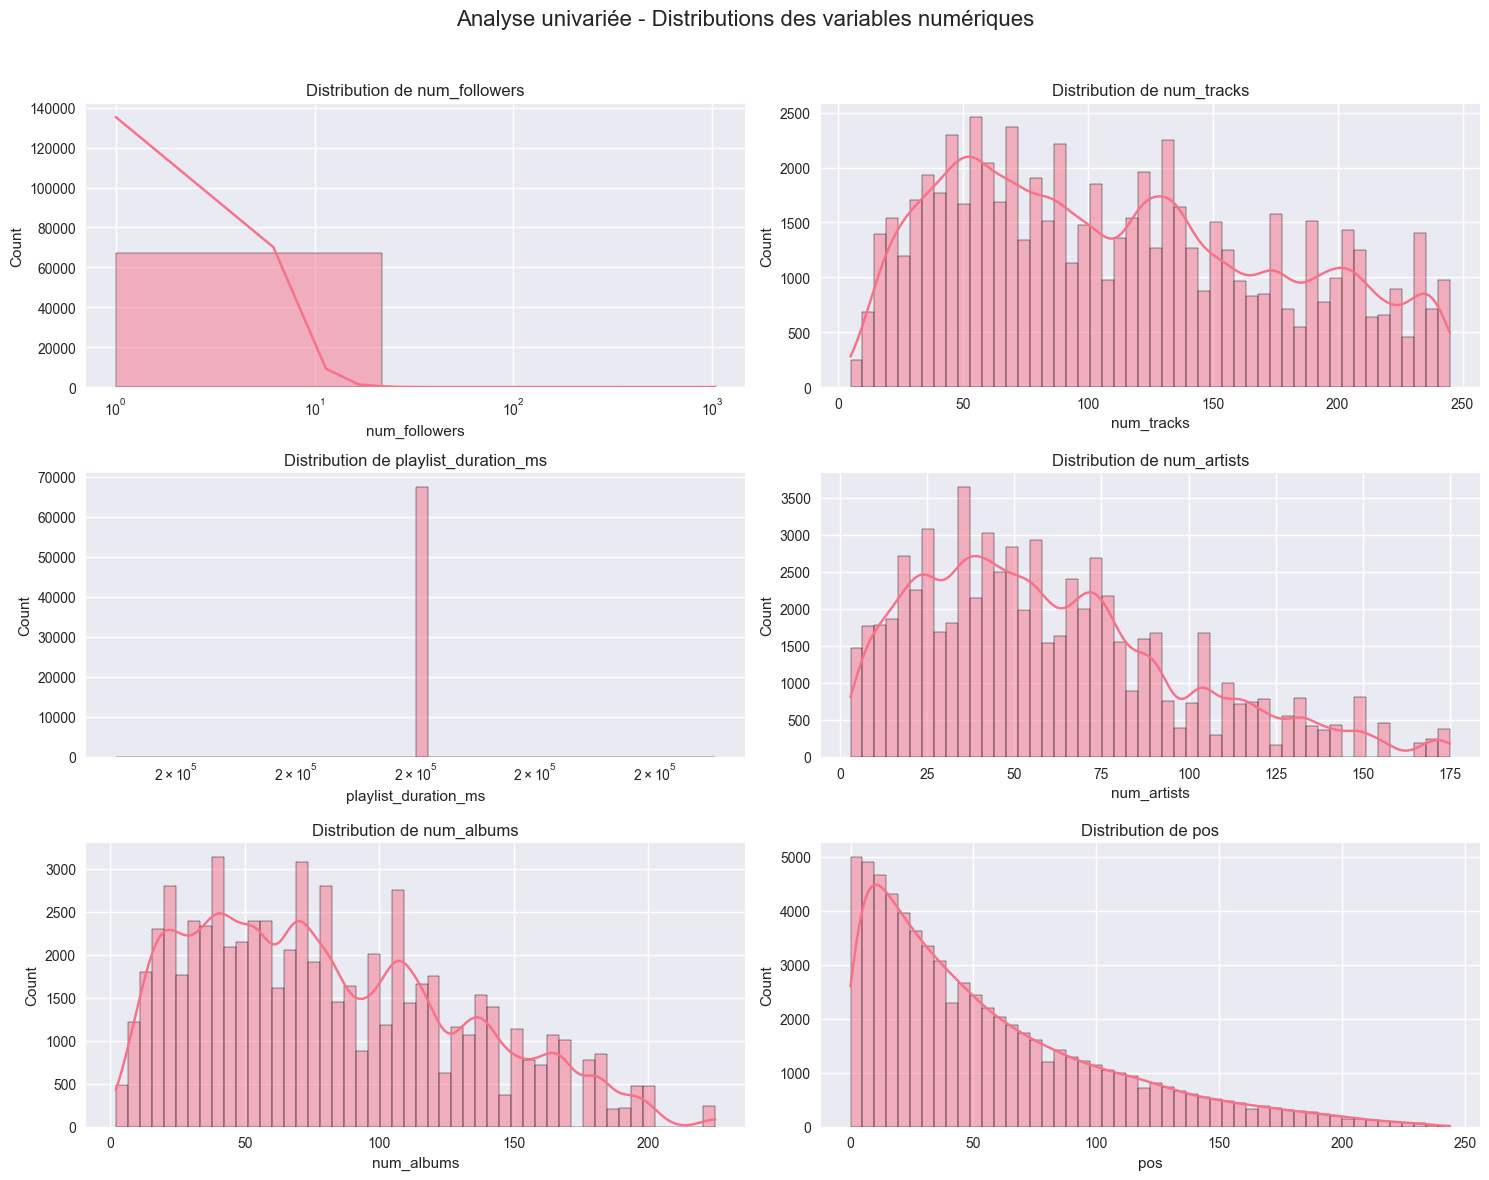

In [29]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'playlist_duration_ms', 'num_artists', 'num_albums', 'pos']
plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univari√©e - Distributions des variables num√©riques', fontsize=16)
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'√©chelle log est utile pour les donn√©es tr√®s asym√©triques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univari√©es sauvegard√©s : {univariate_plot_path}")
plt.show()

In [ ]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'playlist_duration_ms', 'track_duration_ms', 'num_artists', 'num_albums']
plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univari√©e - Distributions des variables num√©riques', fontsize=16)
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'√©chelle log est utile pour les donn√©es tr√®s asym√©triques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univari√©es sauvegard√©s : {univariate_plot_path}")
plt.show()

#################################################################################################

# Boxplots pour les variables num√©riques
plt.figure(figsize=(15, 10))
plt.suptitle('Analyse univari√©e - Boxplots des variables num√©riques', fontsize=16)
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.yscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_box_path = os.path.join(output_dir, 'univar_2_boxplots_numeriques.png')
plt.savefig(univariate_box_path)
print(f"Boxplots sauvegard√©s : {univariate_box_path}")
plt.show()


In [ ]:
# Analyse des variables cat√©gorielles (Top 20)
def plot_top_n(data, column, n, title, path):
    plt.figure(figsize=(12, 8))
    top_n = data[column].value_counts().nlargest(n)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(title)
    plt.xlabel("Nombre d'apparitions")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(path)
    print(f"Graphique '{title}' sauvegard√© : {path}")
    plt.show()

plot_top_n(df, 'artist_name', 20, 'Top 20 des artistes les plus fr√©quents', os.path.join(output_dir, 'univar_3_top20_artistes.png'))
plot_top_n(df, 'album_name', 20, 'Top 20 des albums les plus fr√©quents', os.path.join(output_dir, 'univar_4_top20_albums.png'))

#################################################################################################

# Nuage de mots pour les noms de playlists
playlist_names = ' '.join(df['name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(playlist_names)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des noms de playlists')
wordcloud_path = os.path.join(output_dir, 'univar_5_wordcloud_noms_playlist.png')
plt.savefig(wordcloud_path)
print(f"Nuage de mots sauvegard√© : {wordcloud_path}")
plt.show()


In [ ]:
# B. Analyse bivari√©e
# Matrice de corr√©lation
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Analyse bivari√©e - Matrice de corr√©lation')
bivariate_plot_path = os.path.join(output_dir, 'bivar_1_matrice_correlation.png')
plt.savefig(bivariate_plot_path)
print(f"Matrice de corr√©lation sauvegard√©e : {bivariate_plot_path}")
plt.show()

#################################################################################################

# Pairplot pour les variables cl√©s
pairplot_cols = ['num_followers', 'num_tracks', 'track_duration_ms', 'num_artists']
sns.pairplot(df[pairplot_cols].dropna())
plt.suptitle('Analyse bivari√©e - Pairplot des variables cl√©s', y=1.02)
pairplot_path = os.path.join(output_dir, 'bivar_2_pairplot.png')
plt.savefig(pairplot_path)
print(f"Pairplot sauvegard√© : {pairplot_path}")
plt.show()

#################################################################################################

# Scatter plot sp√©cifique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_tracks', y='num_followers', alpha=0.5)
plt.title('Relation entre le nombre de pistes et le nombre de followers')
plt.xlabel('Nombre de pistes')
plt.ylabel('Nombre de followers')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
scatter_path = os.path.join(output_dir, 'bivar_3_scatter_pistes_followers.png')
plt.savefig(scatter_path)
print(f"Nuage de points sauvegard√© : {scatter_path}")
plt.show()

print("\n--- Analyse exploratoire termin√©e ---")
print(f"Tous les graphiques ont √©t√© sauvegard√©s dans : {output_dir}")


In [ ]:
# Configuration pour l'affichage
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Importation des biblioth√®ques pour l'analyse album/artiste")

#################################################################################################

# Chargement des donn√©es - ADAPT√â POUR NOTEBOOK
base_dir = os.getcwd()  # Utilisation de getcwd() au lieu de dirname(abspath(__file__))
data_path = os.path.join(base_dir, 'alcrowd', 'output', 'alcrowd_cleaned.csv')
output_dir = os.path.join(base_dir, 'alcrowd', 'output')

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Le fichier de donn√©es nettoy√©es n'a pas √©t√© trouv√© : {data_path}\n"
                            "Pensez √† dans un premier temps, ex√©cuter le script de nettoyage des donn√©es.")

df = pd.read_csv(data_path)
print(f"Donn√©es charg√©es depuis '{data_path}'.")
print(f"Dimensions du dataset : {df.shape[0]} lignes et {df.shape[1]} colonnes")

#################################################################################################

# Analyse des playlists uniques
print("\n√âtape 1: Calcul des statistiques par playlist...")

# Grouper par playlist pour obtenir les statistiques uniques
playlists_stats = df.groupby(['name', 'pid']).agg({
    'num_albums': 'first',
    'num_artists': 'first',
    'num_tracks': 'first',
    'artist_name': 'nunique',  # Nombre d'artistes uniques r√©els
    'album_name': 'nunique',   # Nombre d'albums uniques r√©els
    'track_name': 'nunique'    # Nombre de tracks uniques r√©els
}).reset_index()

# Renommage des colonnes pour plus de clart√©
playlists_stats.rename(columns={
    'artist_name': 'artistes_uniques_reels',
    'album_name': 'albums_uniques_reels',
    'track_name': 'tracks_uniques_reels'
}, inplace=True)

# Calculer le ratio albums/artistes
playlists_stats['ratio_albums_artistes'] = (
    playlists_stats['albums_uniques_reels'] / 
    playlists_stats['artistes_uniques_reels']
)

# Calculer la diff√©rence albums - artistes
playlists_stats['diff_albums_artistes'] = (
    playlists_stats['albums_uniques_reels'] - 
    playlists_stats['artistes_uniques_reels']
)

print(f"Statistiques calcul√©es pour {len(playlists_stats)} playlists uniques.")


In [ ]:
# Analyse statistique de l'hypoth√®se
print("\n√âtape 2: Test de l'hypoth√®se de dispersion album/artiste...")

print("="*80)
print("ANALYSE DE L'HYPOTH√àSE : DISPERSION ALBUM/ARTISTE")
print("="*80)

# Statistiques descriptives
print("\n1. STATISTIQUES DESCRIPTIVES")
print("-"*50)
print(f"Nombre total de playlists analys√©es : {len(playlists_stats)}")

print(f"\nAlbums uniques par playlist :")
print(f"  - Moyenne : {playlists_stats['albums_uniques_reels'].mean():.2f}")
print(f"  - M√©diane : {playlists_stats['albums_uniques_reels'].median():.2f}")
print(f"  - √âcart-type : {playlists_stats['albums_uniques_reels'].std():.2f}")

print(f"\nArtistes uniques par playlist :")
print(f"  - Moyenne : {playlists_stats['artistes_uniques_reels'].mean():.2f}")
print(f"  - M√©diane : {playlists_stats['artistes_uniques_reels'].median():.2f}")
print(f"  - √âcart-type : {playlists_stats['artistes_uniques_reels'].std():.2f}")

#################################################################################################

# Test de l'hypoth√®se principale
print("\n2. TEST DE L'HYPOTH√àSE PRINCIPALE")
print("-"*50)

# Pourcentage de playlists avec plus d'albums que d'artistes
plus_albums = (playlists_stats['albums_uniques_reels'] > 
               playlists_stats['artistes_uniques_reels']).sum()
pct_plus_albums = (plus_albums / len(playlists_stats)) * 100

print(f"Playlists avec plus d'albums que d'artistes : {plus_albums}/{len(playlists_stats)} ({pct_plus_albums:.1f}%)")

# Test statistique (test de Wilcoxon pour √©chantillons appari√©s)
statistic, p_value = stats.wilcoxon(
    playlists_stats['albums_uniques_reels'], 
    playlists_stats['artistes_uniques_reels']
)

print(f"\nTest de Wilcoxon (√©chantillons appari√©s) :")
print(f"  - Statistique : {statistic}")
print(f"  - p-value : {p_value:.2e}")
print(f"  - Significatif (Œ±=0.05) : {'Oui' if p_value < 0.05 else 'Non'}")

#################################################################################################

# Analyse du ratio
print("\n3. ANALYSE DU RATIO ALBUMS/ARTISTES")
print("-"*50)
ratio_moyen = playlists_stats['ratio_albums_artistes'].mean()
ratio_median = playlists_stats['ratio_albums_artistes'].median()

print(f"Ratio moyen albums/artistes : {ratio_moyen:.3f}")
print(f"Ratio m√©dian albums/artistes : {ratio_median:.3f}")

# Playlists avec ratio > 1 (plus d'albums que d'artistes)
ratio_sup_1 = (playlists_stats['ratio_albums_artistes'] > 1).sum()
pct_ratio_sup_1 = (ratio_sup_1 / len(playlists_stats)) * 100

print(f"Playlists avec ratio > 1 : {ratio_sup_1}/{len(playlists_stats)} ({pct_ratio_sup_1:.1f}%)")

#################################################################################################

# Distribution de la diff√©rence
print("\n4. ANALYSE DE LA DIFF√âRENCE (ALBUMS - ARTISTES)")
print("-"*50)
diff_positive = (playlists_stats['diff_albums_artistes'] > 0).sum()
pct_diff_positive = (diff_positive / len(playlists_stats)) * 100

print(f"Playlists avec diff√©rence positive : {diff_positive}/{len(playlists_stats)} ({pct_diff_positive:.1f}%)")
print(f"Diff√©rence moyenne : {playlists_stats['diff_albums_artistes'].mean():.2f}")
print(f"Diff√©rence m√©diane : {playlists_stats['diff_albums_artistes'].median():.2f}")

# Stockage des r√©sultats pour les visualisations
resultats = {
    'pct_plus_albums': pct_plus_albums,
    'p_value': p_value,
    'ratio_moyen': ratio_moyen,
    'ratio_median': ratio_median,
    'pct_ratio_sup_1': pct_ratio_sup_1
}


In [ ]:
# Cr√©ation des visualisations techniques
print("\n√âtape 3: Cr√©ation des visualisations techniques...")

# Configuration de la figure avec espacement optimis√©
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Analyse de la Dispersion Album/Artiste dans les Playlists', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Distribution des albums et artistes uniques
axes[0, 0].hist(playlists_stats['albums_uniques_reels'], bins=30, alpha=0.7, 
               label='Albums uniques', color='skyblue')
axes[0, 0].hist(playlists_stats['artistes_uniques_reels'], bins=30, alpha=0.7, 
               label='Artistes uniques', color='lightcoral')
axes[0, 0].set_xlabel('Nombre')
axes[0, 0].set_ylabel('Fr√©quence')
axes[0, 0].set_title('Distribution Albums vs Artistes Uniques')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot Albums vs Artistes
axes[0, 1].scatter(playlists_stats['artistes_uniques_reels'], 
                  playlists_stats['albums_uniques_reels'], 
                  alpha=0.6, s=30)
# Ligne y=x pour r√©f√©rence
max_val = max(playlists_stats['artistes_uniques_reels'].max(), 
              playlists_stats['albums_uniques_reels'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, 
               label='Ligne d\'√©galit√© (y=x)')
axes[0, 1].set_xlabel('Artistes uniques')
axes[0, 1].set_ylabel('Albums uniques')
axes[0, 1].set_title('Relation Albums vs Artistes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution du ratio Albums/Artistes
axes[0, 2].hist(playlists_stats['ratio_albums_artistes'], bins=30, 
               color='orange', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(1, color='red', linestyle='--', linewidth=2, label='Ratio = 1')
axes[0, 2].axvline(ratio_moyen, color='green', linestyle='-', linewidth=2, 
                  label=f'Moyenne = {ratio_moyen:.2f}')
axes[0, 2].set_xlabel('Ratio Albums/Artistes')
axes[0, 2].set_ylabel('Fr√©quence')
axes[0, 2].set_title('Distribution du Ratio Albums/Artistes')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Distribution de la diff√©rence Albums - Artistes
axes[1, 0].hist(playlists_stats['diff_albums_artistes'], bins=30, 
               color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Diff√©rence = 0')
axes[1, 0].set_xlabel('Diff√©rence (Albums - Artistes)')
axes[1, 0].set_ylabel('Fr√©quence')
axes[1, 0].set_title('Distribution de la Diff√©rence Albums - Artistes')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Boxplot comparatif
data_boxplot = [playlists_stats['albums_uniques_reels'], 
                playlists_stats['artistes_uniques_reels']]
axes[1, 1].boxplot(data_boxplot, labels=['Albums', 'Artistes'])
axes[1, 1].set_ylabel('Nombre')
axes[1, 1].set_title('Boxplot Comparatif Albums vs Artistes')
axes[1, 1].grid(True, alpha=0.3)

# 6. Graphique en barres des pourcentages
categories = ['Albums > Artistes', 'Albums = Artistes', 'Albums < Artistes']
egal = (playlists_stats['albums_uniques_reels'] == playlists_stats['artistes_uniques_reels']).sum()
moins = (playlists_stats['albums_uniques_reels'] < playlists_stats['artistes_uniques_reels']).sum()
percentages = [pct_plus_albums, (egal / len(playlists_stats)) * 100, (moins / len(playlists_stats)) * 100]

axes[1, 2].bar(categories, percentages, color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 2].set_ylabel('Pourcentage (%)')
axes[1, 2].set_title('R√©partition des Playlists selon Album/Artiste')
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(percentages):
    axes[1, 2].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n--- Analyse de la dispersion album/artiste termin√©e ---")


In [ ]:
print("Colonnes du DataFrame :", df.columns.tolist())



In [ ]:
print("D√©butons notre analyse exploratoire")

# Cr√©ation d'un dossier de sortie d√©di√© pour les graphiques
output_dir = os.path.join(base_dir, 'alcrowd', 'analyse_exploratoire_plots')
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(cleaned_data_path):
    raise FileNotFoundError(f"Le fichier de donn√©es nettoy√©es n'a pas √©t√© trouv√© : {cleaned_data_path}\n"
                            "Pensez √† dans un premier temps, ex√©cuter le script 'de nettoyage des donn√©es.")

df = pd.read_csv(cleaned_data_path)
print(f"Donn√©es charg√©es depuis '{cleaned_data_path}'.")


In [ ]:
df

In [ ]:
# Analyse Exploratoire (EDA)
print("\nD√©but de l'analyse exploratoire.")

# A. Analyse univari√©e
print("\nStatistiques descriptives des colonnes num√©riques :")
print(df.describe())

In [ ]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'playlist_duration_minutes', 'track_duration_minutes', 'num_artists', 'num_albums']

plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univari√©e - Distributions des variables num√©riques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'√©chelle log est utile pour les donn√©es tr√®s asym√©triques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univari√©es sauvegard√©s : {univariate_plot_path}")
plt.show()
plt.close()


In [ ]:
# Boxplots pour les variables num√©riques
plt.figure(figsize=(15, 10))
plt.suptitle('Analyse univari√©e - Boxplots des variables num√©riques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_box_path = os.path.join(output_dir, 'univar_2_boxplots_numeriques.png')
plt.savefig(univariate_box_path)
print(f"Boxplots sauvegard√©s : {univariate_box_path}")
plt.show()
plt.close()

In [ ]:
# Analyse des variables cat√©gorielles (Top 20)
def plot_top_n(data, column, n, title, path):
    plt.figure(figsize=(12, 8))
    top_n = data[column].value_counts().nlargest(n)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(title)
    plt.xlabel("Nombre d'apparitions")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(path)
    print(f"Graphique '{title}' sauvegard√© : {path}")
    plt.show()
    plt.close()

plot_top_n(df, 'artist_name', 20, 'Top 20 des artistes les plus fr√©quents', os.path.join(output_dir, 'univar_3_top20_artistes.png'))
plot_top_n(df, 'album_name', 20, 'Top 20 des albums les plus fr√©quents', os.path.join(output_dir, 'univar_4_top20_albums.png'))

In [ ]:
# Nuage de mots pour les noms de playlists
playlist_names = ' '.join(df['name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(playlist_names)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des noms de playlists')
wordcloud_path = os.path.join(output_dir, 'univar_5_wordcloud_noms_playlist.png')
plt.savefig(wordcloud_path)
print(f"Nuage de mots sauvegard√© : {wordcloud_path}")
plt.show()
plt.close()

In [ ]:
# B. Analyse bivari√©e
# Matrice de corr√©lation
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Analyse bivari√©e - Matrice de corr√©lation')
bivariate_plot_path = os.path.join(output_dir, 'bivar_1_matrice_correlation.png')
plt.savefig(bivariate_plot_path)
print(f"Matrice de corr√©lation sauvegard√©e : {bivariate_plot_path}")
plt.show()
plt.close()

In [ ]:
# Pairplot pour les variables cl√©s
pairplot_cols = ['num_followers', 'num_tracks', 'track_duration_minutes', 'num_artists']
sns.pairplot(df[pairplot_cols].dropna())
plt.suptitle('Analyse bivari√©e - Pairplot des variables cl√©s', y=1.02)
pairplot_path = os.path.join(output_dir, 'bivar_2_pairplot.png')
plt.savefig(pairplot_path)
print(f"Pairplot sauvegard√© : {pairplot_path}")
plt.show()
plt.close()

In [ ]:
# Scatter plot sp√©cifique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_tracks', y='num_followers', alpha=0.5)
plt.title('Relation entre le nombre de pistes et le nombre de followers')
plt.xlabel('Nombre de pistes')
plt.ylabel('Nombre de followers')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
scatter_path = os.path.join(output_dir, 'bivar_3_scatter_pistes_followers.png')
plt.savefig(scatter_path)
print(f"Nuage de points sauvegard√© : {scatter_path}")
plt.show()
plt.close()

print("\n--- Analyse exploratoire termin√©e ---")
print(f"Tous les graphiques ont √©t√© sauvegard√©s dans : {output_dir}")

# Notebook Maty

In [ ]:
# df = pd.read_csv("alcrowd/alcrowd_cleaned.csv") 
df = pd.read_csv(cleaned_data_path)

# Trouver les 3000 premiers pid (tri√©s)
first_3000_pids = sorted(df['pid'].unique())[:3000]

# Filtrer les morceaux qui appartiennent √† ces playlists
df_3000 = df[df['pid'].isin(first_3000_pids)].copy()

In [ ]:
df_3000

In [ ]:
df.info()

In [ ]:
df.describe()

### PCA

In [ ]:
# Construction de la matrice playlist √ó album
# pivot_df = df.pivot_table(index='pid', columns='album_name', values='track_uri', aggfunc='count', fill_value=0)
df_numerical_columns = [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]
# Standardisation
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pivot_df)
X_scaled = scaler.fit_transform(df[df_numerical_columns])

# Instanciation de l'objet PCA
pca = PCA()

# Application de l'ACP
X_pca = pca.fit_transform(X_scaled)

# Extraction des variances expliqu√©es
explained_variance = pca.explained_variance_ratio_
#print(explained_variance)
cumulative_variance = explained_variance.cumsum()
#print(cumulative_variance)

plt.figure(figsize=(10, 4))

# Variance expliqu√©e par composante
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Variance expliqu√©e par composante")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliqu√©e")

# Variance cumul√©e
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='green')
plt.axhline(0.95, color='red', linestyle='--')
plt.title("Variance expliqu√©e cumul√©e")
plt.xlabel("Nombre de composantes")
plt.ylabel("Cumul de variance")

plt.tight_layout()
plt.show()

In [ ]:
# Perform PCA
pca = PCA(n_components=2)

# Application de l'ACP
X_pca = pca.fit(X_scaled)

# Compute correlations between original features and PCs
correlations = X_pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot the correlation circle
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)

for i, (x, y) in enumerate(correlations):
    plt.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, color='r')
    plt.text(x * 1.1, y * 1.1, df_numerical_columns[i], ha='center', va='center')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f"PC1 ({X_pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({X_pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("PCA Correlation Circle")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Hypoth√®ses
Un album est rarement repr√©sent√© par plus de 2 morceaux dans une playlist

### Maty

In [ ]:
# Construction de la matrice playlist √ó album
pivot_df = df.pivot_table(index='pid', columns='album_name', values='track_uri', aggfunc='count', fill_value=0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)


### K-means : commentaire Giorgio : est-ce que nous en avons besoin comme que nous avons d√©j√† fait la k-means dans les analyses pr√©liminaires ?

In [ ]:
# 1. Calcul de la variable max_tracks_per_album (nombre maximum de morceaux provenant du m√™me album dans la playlist)
max_per_album = df.groupby(['pid', 'album_name']).size().reset_index(name='count')
max_tracks_per_album = max_per_album.groupby('pid')['count'].max().reset_index(name='max_tracks_per_album')

# 2. Agr√©gation des autres infos playlist
playlist_features = df.groupby('pid').agg({
    'num_tracks': 'first',
    'num_albums': 'first',
    'num_artists': 'first',
    'num_followers': 'first',
    'num_edits': 'first',
    'playlist_duration_minutes': 'first'
}).reset_index()

# 3. Fusion de la variable max_tracks_per_album
playlist_df = pd.merge(playlist_features, max_tracks_per_album, on='pid')

# 4. S√©lection des variables pour le clustering (inclut maintenant l‚Äôhypoth√®se)
features = ['num_tracks', 'num_albums', 'num_artists', 'num_followers', 
            'num_edits', 'playlist_duration_minutes', 'max_tracks_per_album']
X = playlist_df[features]

# 5. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. M√©thode du coude
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Trac√© de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie (within-cluster SSE)')
plt.title("M√©thode du coude (elbow method)")
plt.grid(True)
plt.show()


In [ ]:
#k optimal = 4
kmeans = KMeans(n_clusters=4, random_state=42)
playlist_df['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='cluster', y='max_tracks_per_album', data=playlist_df, jitter=0.3, alpha=0.6, palette='Set2')
plt.title("R√©p√©tition maximale d'un album par playlist (par cluster)")
plt.xlabel("Cluster")
plt.ylabel("Max morceaux d'un m√™me album")
plt.grid(True)
plt.show()

Clusters 0 et 1 : majorit√© des points ‚â§ 10 ‚Üí les playlists de ces groupes peuvent confirmer l'hypoth√®se.
Cluster 2 : dispersion plus large, quelques points d√©passent 20, 40, 60, jusqu'√† 100 morceaux du m√™me album ‚Üí forte r√©p√©tition dans certaines playlists ‚Üí contredit partiellement l‚Äôhypoth√®se pour ce groupe.
Cluster 3 : un seul point (cas extr√™me isol√© ?), avec r√©p√©tition de 2 morceaux ‚Üí coh√©rent avec l‚Äôhypoth√®se.

En conclusion, on peut consid√©rer que l'hypoth√®se est v√©rifi√©e car elle reste valide dans la plupart des cas.

## Visualisation

In [ ]:
albums_per_playlist = df.groupby('pid')['album_name'].nunique()
#sns.histplot(albums_per_playlist, bins=30)
sns.barplot(y=albums_per_playlist.index, x=albums_per_playlist.values)
plt.title("Nombre d'albums uniques par playlist")
plt.xlabel("Albums diff√©rents")

In [ ]:
albums_per_playlist = df.groupby('pid')['album_name'].nunique()
print(albums_per_playlist)
print(albums_per_playlist.index)

In [ ]:
# Nombre de playlists diff√©rentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("üé§ Top 3 artistes pr√©sents dans le plus grand nombre de playlists :")
print(artist_playlist_counts)

In [ ]:
# Nombre de playlists diff√©rentes par album
album_playlist_counts = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("\nüíø Top 3 albums pr√©sents dans le plus grand nombre de playlists :")
print(album_playlist_counts)

In [ ]:
top_albums = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)
top_album_names = top_albums.index.tolist()

album_artist_map = (
    df[df['album_name'].isin(top_album_names)]
    .groupby('album_name')['artist_name']
    .agg(lambda x: x.mode().iloc[0])  # artiste le plus fr√©quent pour l‚Äôalbum
)
album_labels = [f"{album_artist_map[album]} ‚Äì {album}" for album in top_album_names]

# Donn√©es du podium
scores = top_albums.values
labels = album_labels

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e √† gauche, 2 = 3e √† droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalis√©es (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libell√©s)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("üèÜ Top 3 albums les plus pr√©sents (format podium)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Nombre de playlists diff√©rentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

# Donn√©es du podium
scores = artist_playlist_counts.values
labels = artist_playlist_counts.index

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e √† gauche, 2 = 3e √† droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalis√©es (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libell√©s)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("üèÜ Top 3 artistes par nombre de playlists diff√©rentes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def classify_playlist_size(n):
    if n < 10:
        return 'Moins de 10'
    elif n < 30:
        return '10-29'
    elif n < 50:
        return '30-49'
    elif n < 100:
        return '50-99'
    else:
        return '100 et +'

df['playlist_size'] = df.groupby('pid')['track_uri'].transform('count')
playlist_size_class = df[['pid', 'playlist_size']].drop_duplicates()
playlist_size_class['taille_cat'] = playlist_size_class['playlist_size'].apply(classify_playlist_size)

# Camembert
size_counts = playlist_size_class['taille_cat'].value_counts().sort_index()
size_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("R√©partition des playlists par taille")
plt.ylabel('')
plt.show()

In [ ]:
# 1. Dur√©e totale par playlist
duration_per_playlist = df.groupby('pid')['track_duration_minutes'].sum().reset_index()

# 2. Conversion en minutes
duration_per_playlist['duration_minutes'] = duration_per_playlist['track_duration_minutes'] / 60000

# 3. Tri des playlists par ID ou dur√©e
duration_per_playlist = duration_per_playlist.sort_values('pid')  # ou .sort_values('duration_minutes')

# 4. Diagramme en ligne
plt.figure(figsize=(12, 5))
sns.lineplot(data=duration_per_playlist, x='pid', y='duration_minutes')
plt.title("‚è±Ô∏è Dur√©e totale des playlists (en minutes)")
plt.xlabel("ID de playlist (pid)")
plt.ylabel("Dur√©e (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()